# Example Parallelized Workflow
This notebook demonstrates how GDTchron uses a parallelized workflow to process large numbers of time-temperature paths quickly. It creates a suite of pseudo-random t-T paths and predicts AHe ages from them using multiple processors, with the number of paths and processors set by the processors available on the system used. The saved output is from a test on a 64 core node on the Tufts HPC Cluster.

In [1]:
# Imports
import os
import time

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np

import gdtchron as gdt

The cell below uses the CPU count of the current system to design a test with the number of cores available on the system.

In [2]:
# Set up number of processesors
max_cores = int(os.cpu_count() / 2)
print('Maximum cores: ', max_cores)
core_list = [int(2**x) for x in range(max_cores) if 2**x <= max_cores]
print('Cores to run for scaling test: ', core_list)

Maximum cores:  64
Cores to run for scaling test:  [1, 2, 4, 8, 16, 32, 64]


The cell below determines the number of paths to run based on the maximum avaialable cores. The number of paths is variable so that the scaling test is as short as possible while still ensuring that performance improvements will still occur at the highest number of processors. The cell then generates the requisite number of paths by pseudo-randomly picking temperatures between 0°C and 75°C for each 100,000 years from 40 Ma to the present.

In [3]:
# Set number of paths based on max cores
n_paths = max_cores * 1500
print('Number of t-T paths: ', n_paths)

# Generate list of pseudo-random t-T paths between 0 and 75 C over 40 Myr
total_time = 40  # Myr
interval = 0.1  # Myr
n_steps = int(total_time / interval) + 1
tsteps = np.arange(total_time, 0 - interval, -interval)  # Myr

rng = np.random.default_rng(17)
temp_paths = [rng.uniform(low=273, high=348, size=n_steps) for x in range(n_paths)]

Number of t-T paths:  96000


The cell below iterates through the core list and runs the t-T paths through GDTchron to predict AHe ages while logging the time it takes to process all paths.

In [4]:
# Run through AHe
times = []
for cores in core_list:
    print(cores, ' cores')
    start = time.time()
    ages = gdt.run_tt_paths(temp_paths=temp_paths, tsteps=tsteps, system='AHe',
                            batch_size=100, processes=cores)
    end = time.time()
    elapsed = end - start
    times.append(elapsed)
    print(cores, ': ', elapsed, ' seconds\n')

1  cores


100%|█████████████████████████████████████████████████████████████████████████████| 96000/96000 [25:34<00:00, 62.57it/s]


1 :  1534.25910282135  seconds

2  cores


100%|████████████████████████████████████████████████████████████████████████████| 96000/96000 [12:43<00:00, 125.81it/s]


2 :  763.2714729309082  seconds

4  cores


100%|████████████████████████████████████████████████████████████████████████████| 96000/96000 [06:27<00:00, 247.82it/s]


4 :  388.79385447502136  seconds

8  cores


100%|████████████████████████████████████████████████████████████████████████████| 96000/96000 [03:11<00:00, 501.97it/s]


8 :  192.71459794044495  seconds

16  cores


100%|███████████████████████████████████████████████████████████████████████████| 96000/96000 [01:35<00:00, 1007.28it/s]


16 :  97.4874198436737  seconds

32  cores


100%|███████████████████████████████████████████████████████████████████████████| 96000/96000 [00:52<00:00, 1839.81it/s]


32 :  54.79542279243469  seconds

64  cores


100%|███████████████████████████████████████████████████████████████████████████| 96000/96000 [00:33<00:00, 2896.26it/s]


64 :  36.645010232925415  seconds



The cell below saves the core list and ages as arrays for re-use so that plotting can take place without needing to re-run the scaling test.

In [5]:
# Create array and write to disk for reuse
output = np.array([core_list, times])
np.save('scaling.npy', output)

age_array = np.array(ages)
np.save('scaling_ages.npy', age_array)

The cell below reloads the saved arrays if the scaling test above was run in a previous session.

In [6]:
# Reload array
output = np.load('scaling.npy')
core_list = output[0]
times = output[1]

ages = np.load('scaling_ages.npy')

The cell below just sets the color used for plotting the results and the name of the device used.

In [7]:
# Color and Device
ahe_color = cmc.batlowS.colors[6]
device = 'Tufts HPC Node (Dual Intel Xeon Gold 6448Y)'

The cell below plots the scaling results along with a histogram showing the ages predicted from the pseudo-random t-T paths.

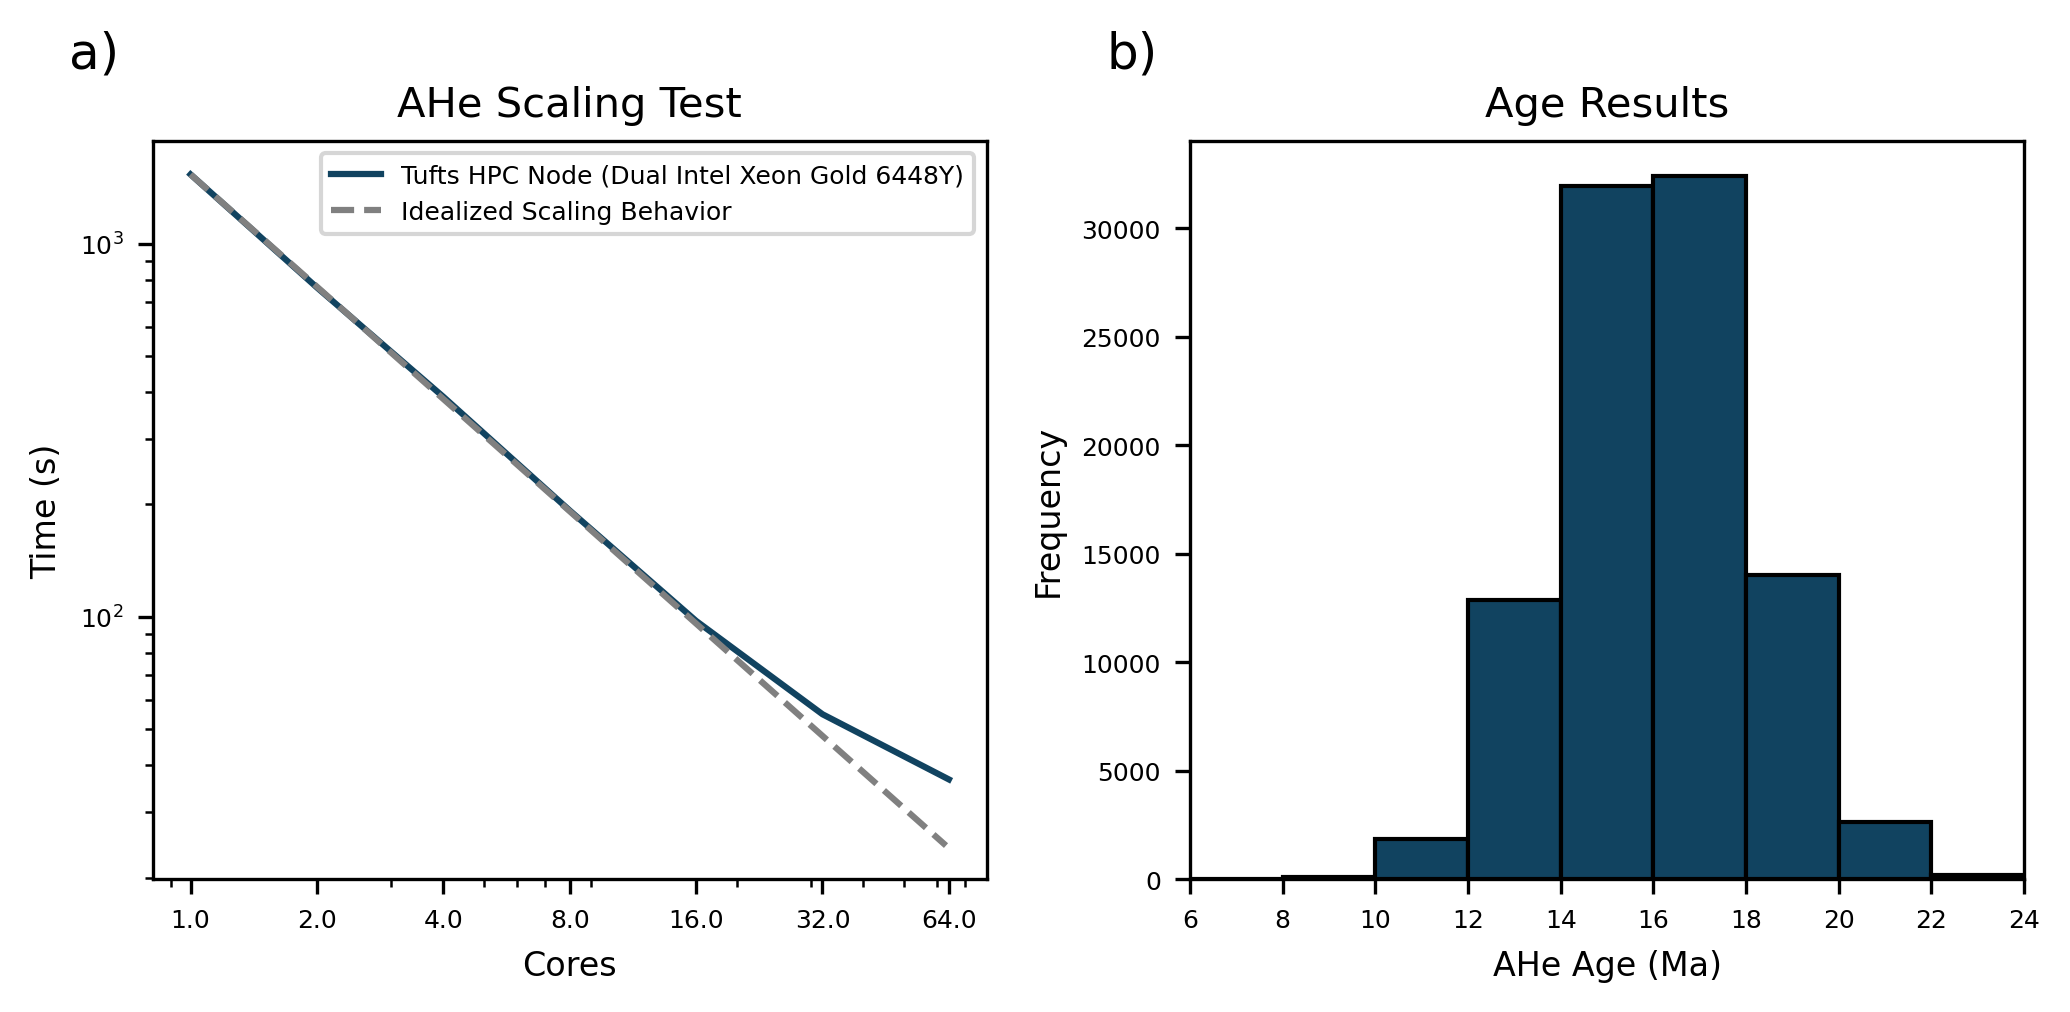

In [8]:
# Plot Scaling Results
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(7, 3.5))

axs[0].plot(core_list, times, c=ahe_color, label=device)
axs[0].loglog()
axs[0].set_xlabel('Cores', fontsize=8)
axs[0].set_ylabel('Time (s)', fontsize=8)
axs[0].set_title('AHe Scaling Test', fontsize=10)

ref_x = np.arange(1, max(core_list), 1).astype(float)
ref_y = max(times) * ref_x**-1
axs[0].plot(ref_x, ref_y, c='grey', linestyle='--', label='Idealized Scaling Behavior')
axs[0].legend(fontsize=6)
axs[0].set_xticks(core_list)
axs[0].set_xticklabels(core_list)

# Plot age results
hist_range = (6, 24)
axs[1].hist(ages, color=ahe_color, edgecolor='black', range=hist_range, bins=9)
axs[1].set_title('Age Results', fontsize=10)
axs[1].set_xlabel('AHe Age (Ma)', fontsize=8)
axs[1].set_ylabel('Frequency', fontsize=8)
axs[1].set_xlim(hist_range)

for k, ax in enumerate(axs):
    ax.tick_params(axis='both', labelsize=6)
    ax.tick_params(which='minor', labelbottom=False, labelleft=False)
    ax.annotate(chr(97 + k) + ')', (-0.1, 1.1), xycoords='axes fraction', fontsize=12) 

plt.tight_layout()
fig.savefig('scaling_test.jpg')
